In [12]:
import numpy as np
import CoolProp.CoolProp as CP
from cycle_functions import *
from scipy.optimize import minimize, Bounds, NonlinearConstraint, LinearConstraint
import warnings
import pandas as pd

def make_cycle(Vars, Inputs, Param):

    # ----------------------------------------------#
    # ==------ Vars  -------==#
    P_c    = Vars[0] # Pa
    P_e    = Vars[1] # Pa
    T_SH   = Vars[2] # delta-T K
    # ----------------------------------------------#
    #==------ Inputs ------==#
    
    T_amb  = Inputs[0] # K
    T_pod  = Inputs[1] # K
    Q_load = Inputs[2] # W
    
    #----------------------------------------------#
    #==------ Param -------==#
    RPM    = Param[0]
    RPM_cond = Param[1]
    RPM_evap = Param[2]
    
    #----------------------------------------------#
    #==-- Init. Outputs  --==#
    P = np.zeros(9) # Pa
    T = np.zeros(9) # K
    h = np.zeros(9) # j/kg
    s = np.zeros(9) # j/kg/k
    abscissa = np.zeros(9)
    # var "abscissa" is the nondimensional 
    # Heat exchanger position 
    # for each of these stations
    # domain = [0,1]U[1,2]
    # [0,1] <-- in condensor
    # [1,2] <-- in evaporator
    
    #=========================================================================#
    # Calculate
    #=========================================================================#

    # pressure drop accross evaporator (Pa)
    delta_P_e = 0
    
    # pressure drop accross condenser (Pa)
    delta_P_c = 0
    
    P[0] = P_e - delta_P_e # Pressure drop accross evap determined empirically
    
    
    # Init state
    T_sat_e = CP.PropsSI('T', 'P', P[0], 'Q', 1, 'R410a') # K
    h_g     = CP.PropsSI('H', 'P', P[0], 'Q', 1, 'R410a') # J/kg
    T[0] = T_sat_e + T_SH
    h[0] = CP.PropsSI('H', 'P', P[0], 'T', T[0], 'R410a')
    abscissa[0] = 0
    s[0] = CP.PropsSI('S', 'P', P[0], 'H', h[0], 'R410a')
    
    STATE   = [P[0], h[0]]
    
    #   calculate compressor
    m_dot_s = compr_func(STATE, RPM, P_c / P[0])
    P[1] = P_c
    
    # Isentropic Ratio
    eta_is = 2.9
   
    h[1] = h[0] + (CP.PropsSI('H', 'P', P_c, 'S', s[0], 'R410a') - h[0]) / eta_is
    s[1] = CP.PropsSI('S', 'P', P[1], 'H', h[1], 'R410a')

    STATE = [P[1], h[1]]
    
    #   calculate condenser
    [P[1:5], T[1:5], h[1:5], s[1:5], abscissa[1:5], W_fan_c] = Condenser_Proc( STATE, 
                                                             'h', m_dot_s, T_amb, delta_P_c, RPM_cond)

    #   calculate expansion
    m_dot_v = capillary_tube_func(P[4], h[4], T[4])
    
    P[5] = P_e
    # Isenthalpic expansion
    h[5] =  h[4]
    
    STATE = [P[5], h[5]]
    

    #   calculate evap
    [P[5:9], T[5:9], h[5:9], s[5:9], abscissa[5:9], W_fan_e] = Evap_Proc(STATE, m_dot_s, T_pod, delta_P_e, RPM_evap)

    abscissa[5:9] = abscissa[5:9] + abscissa[4]

    # Energy and Mass Deficits
    Q_evap = m_dot_s * (h[8] - h[5])
    Q_absr = m_dot_s * (h[0] - h[5])

    m_def  =  (m_dot_s - m_dot_v) / m_dot_s  #Mass Deficit
    h_def  =  (Q_absr  - Q_evap) / Q_evap   #evap deficit
    Q_def  =  (Q_evap  - Q_load) / Q_load   #Pod energy deficit

    Deficit = np.array([m_def, h_def, Q_def])

    #Other Outputs
    m_dot = [m_dot_s, m_dot_v]
    Q_L   = Q_evap
    Q_H   = m_dot_v * (h[1] - h[4])
    
    # Combined efficiency (Regression determined empirically)
    eta_comb = 1 / (P_c / P_e * 31.97243192 -76.62120721)
    
    # Compute compressor work based on isentropic, adiabatic compressor
    W_comp     = m_dot_s * (h[1] - h[0]) / eta_comb

    # Compute Coefficient of system performance
    COSP = Q_L / (W_comp + W_fan_c + W_fan_e)

    return [P, T, h, s, abscissa, m_dot, Q_L, Q_H, W_comp, W_fan_c, W_fan_e, COSP, Deficit]


def adjust_cycle_fmin(Vars, Inputs, Param):

    assert(np.size(Vars) == 3)

    T_amb  = Inputs[0]
    T_pod  = Inputs[1]

    #
    #
    # Make Objective Function

    def objective(Vars):
        [_, _, _, _, _, _, _, _, _, _, _, _, Obj] = make_cycle(Vars, Inputs, Param)
        
        Obj = 1000 * np.linalg.norm(Obj)
        
        return Obj
                        
    #
    #
    # Make Nonlinear Constraint for T_SH

    def nonlcon(Vars):
        c = (T_pod - CP.PropsSI('T', 'P', Vars[1], 'Q', 0, 'R410a')) - Vars[2] 
        return c

    nonLinear = NonlinearConstraint(nonlcon, 0, np.inf)
    
    linear = LinearConstraint(np.vstack([np.identity(len(Vars)), [1, -3.2, 0]]),
                              [CP.PropsSI('P', 'T', T_amb, 'Q', 1, 'R410a'), 200e3, 0.1, -np.inf], # Lower Bounds
                              [5000e3, CP.PropsSI('P', 'T', T_pod, 'Q', 0, 'R410a'), 30, 0] # Upper Bounds
                             )

    #
    # Solve the problem.
    try:
        res = minimize(objective, Vars, constraints = [nonLinear, linear], 
                       method = 'trust-constr', options = {'maxiter': 500})
    except ValueError as e:
        print(e)
        print('initial Point: ' + str(Vars))
        res = {'success': False}
    
    # ---
    if res['success']:
        Vars = res.x
        [_, _, _, _, _, _, _, _, _, _, _, _, Deficit] = make_cycle(Vars, Inputs, Param)
    else:
        Deficit = [1, 1, 1]

    return [Vars, Deficit]


def solve_cycle_shotgun(Inputs, Param):
    
    T_amb  = Inputs[0] # K
    T_pod  = Inputs[1] # K
    
    SPREAD = 4;

    # evaporator bounds
    lb = [200e3, CP.PropsSI('P', 'T', T_amb, 'Q', 1, 'R410a')] # lower bound for evap and cond Pressures
    ub = [CP.PropsSI('P', 'T', T_pod, 'Q', 0, 'R410a'), 3.2] # upper bound for evap and compression ratio bound for cond

    #Starting points
    P_e   = lb[0] + (ub[0] - lb[0]) * np.linspace( 0.1, 0.9, SPREAD)
    P_c   = P_e + (P_e * ub[1] - lb[1]) * np.linspace( 0.1, 0.9, SPREAD)
    
    T_SH  = .5

    # Create list of possible combinations of pressures
    Vars = np.array(np.meshgrid(P_c, P_e, T_SH)).T.reshape(-1, 3)

    #Initialize Vars and Deficits
    normDeficit = np.zeros(len(Vars))
    Deficit     = np.zeros((len(Vars), 3))

    # Try different initial points
    for ind, Var in enumerate(Vars):
        #Step Vars Forward
        [Vars[ind], Deficit[ind]] = adjust_cycle_fmin( Var, Inputs, Param)
        normDeficit[ind] = np.linalg.norm(Deficit[ind])
        
    
    # find solution with lowest error
    Vars = Vars[normDeficit == np.nanmin(normDeficit)][0]
    
    # Check if error is lower than 3% 
    converged = 1
    if normDeficit[normDeficit == np.nanmin(normDeficit)] > 0.05:
        converged = 0
        warnings.warn('Warning: |Deficit| = ' + 
                      str(normDeficit[normDeficit == min(normDeficit)]))

    #Calc
    [ P, T, h, s, abcissa, m_dot, Q_L, Q_H, W_comp, W_fan_c, W_fan_e, COSP, Deficit] = make_cycle(Vars, 
                                                                                             Inputs,
                                                                                             Param)
    Props = [P, T, h, s, abcissa]
        
    return [Props, m_dot, Q_L, Q_H, W_comp, W_fan_c, W_fan_e, COSP, Deficit, converged]

In [13]:
def generate_HTCOEFF(P, m_dot_g, m_dot_f, V_dot, subsys, T_air):

    if subsys == 'EVAP':
        
        # Geometric Characteristics
        
        # Fin density (fins/m) [measured 20 fins per inch]
        Nf = 19 / 0.0254

        # Outside diameter of tubing (m) [measured .31"]
        do = 5 / 16 * 0.0254

        # Inside diameter of tubing (m) [wall thickness estimated at 0.03"]
        di = do - 2 * 0.03 * 0.0254

        # Transverse spacing between tubes (m) [measured 0.86"]
        xt = 0.86 * 0.0254

        # Longitudinal spacing between tubes (m) [(measured 0.994") / 2]
        xl = (0.994 * 0.0254) / 2

        # Fin thickness (m) [measured 0.004"]
        delta = 0.004 * 0.0254

        # Overall Length (m) 
        L1 = (12.5) * 0.0254
        
        # Overall depth (m) [measured 1.75"]
        L2 = (1.5) * 0.0254

        # Overall height (m) 
        L3 = 8.5 * 0.0254
        
        # Number of Rows 
        Nr = 3
        
        # Number of tubes
        Nt = 30

        #Interior (refrigerant side)
        A_i = np.pi * di * Nt * L1 # [m2]

        #Pipe Wall
        k_pipe = 385 # copper [W/m-K]

        R_tw = np.log(do / di) / (2 * np.pi * k_pipe * Nt * L1) # [K/W]

        #Exterior (air side)
        
        # Primary surface area (tubes and header plates)
        A_p = np.pi * do * (L1 - delta * Nf * L1) * Nt + 2 * (L3 * L2 - np.pi * do**2 / 4 * Nt)

        # Secondary surface area (fins)
        A_f = 2 * (L2 * L3 - (np.pi * do**2 /  4) * Nt) * Nf * L1 + 2 * L3 * delta * Nf * L1 
        
        A_a = A_f + A_p #[m2] #Heat transfer area airside
        
        # Volume occupied by the heat exchanger (heat exchanger total volume) (m^3)
        V_a = L1 * L2 * L3
        
        # Minimum free-flow area (Fundamentals of Heat Exchanger Design-Shah pg 573) 

        # 2a''
        a_prime = (xt - do) - (xt - do) * delta * Nf 

        # 2b''
        b_prime = 2 * (((xt / 2) ** 2 + xl ** 2) ** 0.5 - do - (xt - do) * delta * Nf)

        # c''
        if a_prime < b_prime:
            c_prime = a_prime
        else:
            c_prime = b_prime

        # Minimum free-flow area (m^2)
        A_o_a = ((L3 / xt - 1) * c_prime + (xt - do) - (xt - do) * delta * Nf) * L1

        # Frontal area (m^2)
        A_fr_a = L1 * L3

        # Ratio of free flow area to frontal area
        sigma_a  = A_o_a / A_fr_a

        # surface area density 
        alpha_a = A_a / V_a

        # Hydralic diameter (m)
        D_h_a = 4 * sigma_a / alpha_a
        
        # Mean velocity accross HX (m/s)
        V_extr = V_dot / A_fr_a

        # Maximum velocity inside the HX (m/s)
        V_max = V_extr / sigma_a

        #-------------------------------------------------------------------------#
        # Refrigerant Constants (R410a) 
        #-------------------------------------------------------------------------#

        k_f  = CP.PropsSI('L', 'P', P, 'Q', 0, 'R410a') # [W/m-K] 
        k_g  = CP.PropsSI('L', 'P', P, 'Q', 1, 'R410a') # [W/m-K] 
        mu_f = CP.PropsSI('V', 'P', P, 'Q', 0, 'R410a') # [Pa-s] 
        mu_g = CP.PropsSI('V', 'P', P, 'Q', 1, 'R410a') # [Pa-s]
        c_p_f = CP.PropsSI('C', 'P', P, 'Q', 0, 'R410a') #[J/kg-K]  
        c_p_g = CP.PropsSI('C', 'P', P, 'Q', 1, 'R410a') #[J/kg-K]           

        #-------------------------------------------------------------------------#
        # Air Constants
        #-------------------------------------------------------------------------#

        k_a = CP.PropsSI('L', 'P', 101325, 'T', T_air, 'air') #[W/m-K]   
        mu_a = CP.PropsSI('V', 'P', 101325, 'T', T_air, 'air') #[Pa-s]   
        rho_a = CP.PropsSI('D', 'P', 101325, 'T', T_air, 'air') #[kg/m3] 
        c_p_a = CP.PropsSI('C', 'P', 101325, 'T', T_air, 'air') #[J/kg-K]
        Pr_a = CP.PropsSI('Prandtl', 'P', 101325, 'T', T_air, 'air') #[J/kg-K]

        #-------------------------------------------------------------------------#
        # Derived Relations
        #-------------------------------------------------------------------------#
        
        # fluid mass velocity (kg/(m^2 s))
        G_a = A_fr_a * V_extr * rho_a / A_o_a

        # Compute Reynold's number
        Re_a = G_a * D_h_a / mu_a

        # Compute j using equation 7.141 Nr >= 2 (Fundamentals of Heat Exchanger Design-Shah pg 551)

        # collar diameter (m)
        dc = do + 2 * delta

        # Collar Reynolds number
        Re_dc = rho_a * V_max * dc / mu_a

        # fin pitch (m/fin)
        pf = 1 / Nf

        # constants from equation
        C3 = -0.361 - 0.042 * Nr / np.log(Re_dc) + 0.158 * np.log(Nr * (pf / dc) **0.41)

        C4 = -1.224 - (0.076 * (xl / D_h_a) ** 1.42) / np.log(Re_dc)

        C5 = -0.083 + 0.058 * Nr / np.log(Re_dc)

        C6 = -5.735 + 1.21 * np.log(Re_dc / Nr)

        # Compute outside heat transfer coefficeinet using colburn j factor (more accurate)
        j = 0.086 * Re_dc ** C3 * Nr ** C4 * (pf / dc) ** C5 * (pf / D_h_a) ** C6 * (pf / xt) ** -0.93

        # h = JGCp/Pr^2/3
        h_a = j * V_max * c_p_a / Pr_a**(2/3)

        # radius of tube including collar thickness
        r_e = dc / 2

        # Single fin efficiency 
        # (Fundamentals of Heat Exchanger Design-Shah pg 606 eqn 9.14)
        m = (2 * h_a / k_pipe / delta) ** 0.5
        
        # geometric parameter for schmidt fin efficieny approx.
        xm = xt / 2

        # equivelent fin radius
        R_eq = r_e * (1.27 * xm / r_e * ((np.sqrt((xt / 2)**2 + xl**2) / 2) / xm - 0.3)**0.5)
        
        # Phi parameter for staggered arrangement
        phi  = (R_eq / r_e - 1) * (1 + 0.35 * np.log(R_eq / r_e))
        
        # Determine single fin efficiency
        eta_f = np.tanh(m * r_e * phi) / (m * r_e * phi)
        
        #Overall Fin efficiency
        fin_eff = 1 - (1 - eta_f) * A_f / A_a

        #HT-coefficient, gaseous, contribution from refrigerant side
        Re_g  =  4 * m_dot_g / (np.pi * di * mu_g)
        Pr_g  =  c_p_g * mu_g / k_g
        Nu_g  =  Circular_Duct_Nu([Re_g], [Pr_g], 'c')  
        h_i_g =  k_g * Nu_g / di


        #HT-coefficient, liquid, contribution from refrigerant side
        Re_f  =  4 * m_dot_f / (np.pi * di * mu_f)
        Pr_f  =  c_p_f * mu_f / k_f
        Nu_f  =  Circular_Duct_Nu([Re_f], [Pr_f], 'c')
        h_i_f =  k_f * Nu_f / di

        
        UA_g = (1 / (h_i_g * A_i) + R_tw + 1 / (fin_eff * h_a * A_a))**-1
        UA_f = (1 / (h_i_f * A_i) + R_tw + 1 / (fin_eff * h_a * A_a))**-1

        #Local overall heat transfer coefficient
        U_g = UA_g / A_i
        U_f = UA_f / A_i

    elif subsys == 'COND':

        # Geometric Characteristics
        
        # Fin density (fins/m) [measured 19 fins per inch]
        Nf = 19 / 0.0254

        # Outside diameter of tubing (m) [measured .25"]
        do = 1 / 4 * 0.0254

        # Inside diameter of tubing (m) [wall thickness estimated at 0.03"]
        di = do - 2 * 0.03 * .0254

        # Transverse spacing between tubes (m) [measured 1.048" - do]
        xt = 1.048 * 0.0254 - do

        # Longitudinal spacing between tubes (m) [(measured 1.066" - do) / 2]
        xl = (1.066 * 0.0254 - do) / 2

        # Fin thickness (m) [measured 0.004"]
        delta = 0.004 * 0.0254

        # Overall Length (m) [measured 15 + 15/16 ] (parially blocked by compressor!)
        L1 = (9) * 0.0254
        
        # Overall depth (m) [measured 1.5]
        L2 = (1.5) * 0.0254

        # Overall height (m) [measured 12.5"] (parially blocked by compressor!)
        L3 = (10) * 0.0254
        
        # Number of Rows 
        Nr = 3
        
        # Number of tubes. Two tube slots are empty
        Nt = 44 - 2

        #Interior (refrigerant side)
        A_i = np.pi * di * Nt * L1 # [m2]

        #Pipe Wall
        k_pipe = 385 # copper [W/m-K]

        R_tw = np.log(do / di) / (2 * np.pi * k_pipe * Nt * L1) # [K/W]

        #Exterior (air side)
        
        # Primary surface area (tubes and header plates)
        A_p = np.pi * do * (L1 - delta * Nf * L1) * Nt + 2 * (L3 * L2 - np.pi * do**2 / 4 * Nt)

        # Secondary surface area (fins)
        A_f = 2 * (L2 * L3 - (np.pi * do**2 / 4) * Nt) * Nf * L1 + 2 * L3 * delta * Nf * L1 
        
        A_a = A_f + A_p #[m2] #Heat transfer area airside
        
        # Volume occupied by the heat exchanger (heat exchanger total volume) (m^3)
        V_a = L1 * L2 * L3
        
        # Minimum free-flow area (Fundamentals of Heat Exchanger Design-Shah pg 573) 

        # 2a''
        a_prime = (xt - do) - (xt - do) * delta * Nf 

        # 2b''
        b_prime = 2 * (((xt / 2) ** 2 + xl ** 2) ** 0.5 - do - (xt - do) * delta * Nf)

        # c''
        if a_prime < b_prime:
            c_prime = a_prime
        else:
            c_prime = b_prime

        # Minimum free-flow area (m^2)
        A_o_a = ((L3 / xt - 1) * c_prime + (xt - do) - (xt - do) * delta * Nf) * L1

        # Frontal area (m^2)
        A_fr_a = L1 * L3

        # Ratio of free flow area to frontal area
        sigma_a  = A_o_a / A_fr_a

        # surface area density 
        alpha_a = A_a / V_a

        # Hydralic diameter (m)
        D_h_a = 4 * sigma_a / alpha_a
        
        # Mean velocity accross HX (m/s)
        V_extr = 0.01 * V_dot / A_fr_a

        # Maximum velocity inside the HX (m/s)
        V_max = V_extr / sigma_a 

        #-------------------------------------------------------------------------#
        # Refrigerant Constants (R410a) 
        #-------------------------------------------------------------------------#

        k_f  = CP.PropsSI('L', 'P', P, 'Q', 0, 'R410a') # [W/m-K] 
        k_g  = CP.PropsSI('L', 'P', P, 'Q', 1, 'R410a') # [W/m-K] 
        mu_f = CP.PropsSI('V', 'P', P, 'Q', 0, 'R410a') # [Pa-s] 
        mu_g = CP.PropsSI('V', 'P', P, 'Q', 1, 'R410a') # [Pa-s]
        c_p_f = CP.PropsSI('C', 'P', P, 'Q', 0, 'R410a') #[J/kg-K]  
        c_p_g = CP.PropsSI('C', 'P', P, 'Q', 1, 'R410a') #[J/kg-K]           

        #-------------------------------------------------------------------------#
        # Air Constants
        #-------------------------------------------------------------------------#

        k_a = CP.PropsSI('L', 'P', 101325, 'T', T_air, 'air') #[W/m-K]   
        mu_a = CP.PropsSI('V', 'P', 101325, 'T', T_air, 'air') #[Pa-s]   
        rho_a = CP.PropsSI('D', 'P', 101325, 'T', T_air, 'air') #[kg/m3] 
        c_p_a = CP.PropsSI('C', 'P', 101325, 'T', T_air, 'air') #[J/kg-K]
        Pr_a = CP.PropsSI('Prandtl', 'P', 101325, 'T', T_air, 'air') #[J/kg-K]

        #-------------------------------------------------------------------------#
        # Derived Relations
        #-------------------------------------------------------------------------#
        
        # fluid mass velocity (kg/(m^2 s))
        G_a = A_fr_a * V_extr * rho_a / A_o_a

        # Compute Reynold's number
        Re_a = G_a * D_h_a / mu_a

        # Compute j using equation 7.141 Nr >= 2 (Fundamentals of Heat Exchanger Design-Shah pg 551)

        # collar diameter (m)
        dc = do + 2 * delta

        # Collar Reynolds number
        Re_dc = rho_a * V_max * dc / mu_a

        # fin pitch (m/fin)
        pf = 1 / Nf

        # constants from equation
        C3 = -0.361 - 0.042 * Nr / np.log(Re_dc) + 0.158 * np.log(Nr * (pf / dc) **0.41)

        C4 = -1.224 - 0.076 * (xl / D_h_a) ** 1.42 / np.log(Re_dc)

        C5 = -0.083 + 0.058 * Nr / np.log(Re_dc)

        C6 = -5.735 + 1.21 * np.log(Re_dc / Nr)

        # Compute outside heat transfer coefficeinet using coburn j factor (more accurate)
        j = 0.086 * Re_dc ** C3 * Nr ** C4 * (pf / dc) ** C5 * (pf / D_h_a) ** C6 * (pf / xt) ** -0.93

        # h = JGCp/Pr^2/3
        h_a = j * V_max * c_p_a / Pr_a ** (2/3)
        
        # radius of tube including collar thickness
        r_e = dc / 2

        # Single fin efficiency 
        # (Fundamentals of Heat Exchanger Design-Shah pg 606 eqn 9.14)
        m = (2 * h_a / k_pipe / delta) ** 0.5
        
        # geometric parameter for schidt fin efficieny approx.
        xm = xt / 2

        # equivelent fin radius
        R_eq = r_e * (1.27 * xm / r_e * ((np.sqrt((xt / 2)**2 + xl**2) / 2) / xm - 0.3)**0.5)
        
        # Phi parameter for staggered arrangement
        phi  = (R_eq / r_e - 1) * (1 + 0.35 * np.log(R_eq / r_e))
        
        # Determine single fin efficiency
        eta_f = np.tanh(m * r_e * phi) / (m * r_e * phi)
        
        #Overall Fin efficiency
        fin_eff = (1 - (1 - eta_f) * A_f / A_a)

        #HT-coefficient, gaseous, contribution from refrigerant side
        Re_g  =  4 * m_dot_g / (np.pi * di * mu_g)
        Pr_g  =  c_p_g * mu_g / k_g
        Nu_g  =  Circular_Duct_Nu([Re_g], [Pr_g], 'h')  
        h_i_g =  k_g * Nu_g / di


        #HT-coefficient, liquid, contribution from refrigerant side
        Re_f  =  4 * m_dot_f / (np.pi * di * mu_f)
        Pr_f  =  c_p_f * mu_f / k_f
        Nu_f  =  Circular_Duct_Nu([Re_f], [Pr_f], 'h')
        h_i_f =  k_f * Nu_f / di


        UA_g = (1 / (h_i_g * A_i) + R_tw + 1 / (fin_eff * h_a * A_a))**-1
        UA_f = (1 / (h_i_f * A_i) + R_tw + 1 / (fin_eff * h_a * A_a))**-1

        #Local overall heat transfer coefficient
        U_g = UA_g / A_i
        U_f = UA_f / A_i

    else:
        raise ValueError('Subsys must be "COND" or "EVAP"')
    return [UA_g, UA_f]

In [14]:
def Condenser_Proc(input_state, strarg, flowrate, T_amb, P_drop, RPM):


    # Input state must be a row vector containing pressure 
    # and enthalpy in that order
    # input_state = [P, h]
    
    # Compute fan work and volumetric flow rate based on fan rpm
    [V_dot, W_fan] = fan(RPM)
    
    #Initialize Vars
    #----------------------
    P_in = input_state[0]
    P = P_in * np.ones(4)
    h = np.zeros(4)
    T = np.zeros(4)
    s = np.zeros(4)

    abcissa = np.zeros(4)
    dz_1 = 0
    dz_2 = 0
    dz_3 = 0

    #=========================================================================#
    # set up us the properties

    if strarg == 'h':

        h_in = input_state[1]
        T_in = CP.PropsSI('T', 'P', P_in, 'H', h_in, 'R410a')
        T_sat = CP.PropsSI('T', 'P', P_in, 'Q', 1, 'R410a')
        h_f   = CP.PropsSI('H', 'P', P_in, 'Q', 0, 'R410a')
        h_g   = CP.PropsSI('H', 'P', P_in, 'Q', 1, 'R410a')
        h_fg  = h_g - h_f    
 
    
#         T_in  = fsolve(lambda t: ((h_in-h_g) - SuperHT_Cp_integral(T_sat, t)), 
#                        T_sat + 1)


        # assign output
        #----------------
        T[0] = T_in;
        h[0] = h_in;
        #----------------

    elif strarg == 'T':

        T_in = input_state[1];
        h_in = CP.PropsSI('H', 'P', P_in, 'T', T_in, 'R410a')
        T_sat = CP.PropsSI('T', 'P', P_in, 'Q', 1, 'R410a')
        h_f   = CP.PropsSI('H', 'P', P_in, 'Q', 0, 'R410a')
        h_g   = CP.PropsSI('H', 'P', P_in, 'Q', 1, 'R410a')
        h_fg  = h_g - h_f;

#         h_in  = h_g + SuperHT_Cp_integral(T_sat, T_in);


        # assign output
        #----------------
        T[0] = T_in;
        h[0] = h_in;
        #----------------

    else:
        raise ValueError('dont recognize input property' + strarg)



    #=========================================================================#
    # Calculate Vars
    #

    [UA_1, UA_3] = generate_HTCOEFF( P_in, flowrate, flowrate, 
                                       V_dot, 'COND', T_amb)
    

    #Temporary
    UA_g = UA_1
    UA_f = UA_3

    #Properties
    c_p_g = 0.5 * (CP.PropsSI('C', 'P', P_in, 'H', h_in, 'R410a') + 
                   CP.PropsSI('C', 'P', P_in, 'Q', 1, 'R410a'))
    
    c_p_f = CP.PropsSI('C', 'P', P_in, 'Q', 0, 'R410a')

    rho_g   = CP.PropsSI('D', 'P', P_in, 'Q', 1, 'R410a')
    rho_f   = CP.PropsSI('D', 'P', P_in, 'Q', 0, 'R410a')
    rho_rat = rho_g / rho_f

    #Vol Void Frac
    gamma = 1 / (1 - rho_rat) + rho_rat / (rho_rat - 1)**2 * np.log( rho_rat )

    UA_2 = UA_f * (1 - gamma) + UA_g * (gamma)




    #=========================================================================#
    #
    #  begin integration procedure, piecewise
    #
    #

    #--- Superheat-into-Saturation Process ---
    # Check that ambiet temperature is above the saturation 
    # and inlet temperature otherwise go straight to subcooled
    if (T_amb - T_in) < 0  and (T_amb - T_sat) < 0:
        dz_1 = c_p_g  * flowrate / UA_1 * - np.log((T_sat - T_amb) / (T_in - T_amb))

        #Add exception if superheated phase takes up the
        #entire HX domain
        if (dz_1 > 1):
            T = np.nan
            h = np.nan
            P = np.nan
            abcissa = np.nan
            raise ValueError('no exception when superheated' +
                             ' phase takes up entire domain')


        T[1] = T_sat
        h[1] = h_g


        #--- SatVap-into-SatLiq Process ---

        dz_2 = flowrate * h_fg / (UA_2 * (T_sat - T_amb))

            #Begin exception if saturation phase takes up the 
            #remainder of the HX domain
        if (dz_1 + dz_2) > 1:

            dz_2   = 1 - dz_1

            #solve system 
            #gamma and delta_h are the variables\
            x = lambda dh: (dh + h_fg) / h_fg # x(var[1])
            f = lambda var: [dz_2 * (T_amb - T_sat) * 
                             (UA_f + (UA_g - UA_f) * var[0]) - 
                             (flowrate * var[1]),

                             (1 - x(var[1])) * 
                             (1 / (1 - rho_rat) - var[0]) + 
                             rho_rat / (rho_rat - 1)**2 * 
                             np.log(rho_rat + (1 - rho_rat) * 
                                    x(var[1]))
                            ]

            b = fsolve( f, [gamma, -h_fg] )
            # gamma = b(1);
            dh_2  = b[1]

            #-----------------
            # Produce Output
            #
            h_out = h_g + dh_2;
            #
            # assign output
            #-----------------
            T[2] = T_sat
            h[2] = h_out
            T[3] = T[2]
            h[3] = h[2]
            #-----------------

            #Otherwise go to subcool process  
        else:

            # assign output
            #-----------------
            T[2] = T_sat
            h[2] = h_f
            #-----------------      



    #--- SatLiq-into-Subcool Process ---        

    dz_3 = 1 - dz_1 - dz_2

    T_out = (T_sat - T_amb) * np.exp(-UA_3 / (c_p_f * 
                                              flowrate) * dz_3) + T_amb
    h_out = h_f + c_p_f * (T_out - T_sat)


    # assign output
    #-----------------
    T[3] = T_out;
    h[3] = h_out;
    
    # Pressure drop determined empirically applied linearly
    P[1] = P[0] - P_drop * dz_1
    P[2] = P[1] - P_drop * dz_2
    P[3] = P[2] - P_drop * (1 - dz_2 + dz_1)
    #-----------------


    # assign output
    #-----------------------------------
    abcissa[1] = abcissa[0] + dz_1
    abcissa[2] = abcissa[1] + dz_2
    abcissa[3] = 1
    #-----------------------------------    

    s = CP.PropsSI('S', 'P', P, 'H', h, 'R410a')


    return [P, T, h, s, abcissa, W_fan]

In [15]:
def Evap_Proc(input_state, flowrate, T_pod, P_drop, RPM):


    # Input state must be a row vector containing pressure 
    # and enthalpy in that order
    # input_state = [P, h]

    # Compute fan work and volumetric flow rate based on fan rpm
    [V_dot, W_fan] = fan(RPM)

    #
    # Initialize Vars
    #----------------------
    P_in = input_state[0]
    P = P_in * np.ones(4)
    h = np.zeros(4)
    T = np.zeros(4)
    s = np.zeros(4)

    abcissa = np.zeros(4)
    dz_1 = 0
    dz_2 = 0
    dz_3 = 0


    #=========================================================================#
    # set up us the properties
    #
    h_in  = input_state[1]

    T_sat = CP.PropsSI('T', 'P', P_in, 'Q', 1, 'R410a')
    h_f   = CP.PropsSI('H', 'P', P_in, 'Q', 0, 'R410a')
    h_g   = CP.PropsSI('H', 'P', P_in, 'Q', 1, 'R410a')
    h_fg  = h_g - h_f    


    #=========================================================================#
    # Calculate Vars
    #

    [UA_1, UA_3] = generate_HTCOEFF( P_in, flowrate, flowrate, V_dot, 'EVAP', T_pod);

    #Temporary
    UA_g = UA_3;
    UA_f = UA_1;


    #Properties
    c_p_g = CP.PropsSI('C', 'P', P_in, 'Q', 1, 'R410a')
    c_p_f = CP.PropsSI('C', 'P', P_in, 'Q', 0, 'R410a')

    rho_g   = CP.PropsSI('D', 'P', P_in, 'Q', 1, 'R410a')
    rho_f   = CP.PropsSI('D', 'P', P_in, 'Q', 0, 'R410a')
    rho_rat = rho_g / rho_f




    #=========================================================================#
    #
    #  begin integration procedure, piecewise
    #
    #=

    if h_in >= h_f:  #There is no subcooled region

        dz_1 = 0;
        # assign output
        #----------------
        T[0] = T_sat;
        h[0] = h_in;
        T[1] = T_sat;
        h[1] = h_in;
        #----------------
        
        #Vol Void Frac
        x_in  = (h_in - h_f) / h_fg
        gamma = (1 / ( 1 - rho_rat) + rho_rat / (rho_rat - 1)**2 / 
                 (1 - x_in) * np.log( x_in - rho_rat * (x_in - 1)))

        #Twophase region HT coeff
        UA_2 = UA_f * (1 - gamma) + UA_g * (gamma)



    else: #calculate subcooled region
    #--- Subcooled-into-SatLiq Process ---

        T_in = T_sat + (h_in - h_f) / c_p_f

        dh_1 = h_f - h_in;
        dz_1 = (c_p_f * flowrate / UA_1 ) * np.log( (T_pod - T_in) / (T_pod - T_sat));

        # assign output
        #----------------
        T[0] = T_in;
        h[0] = h_in;
        T[1] = T_sat;
        h[1] = h_f;
        #----------------

        #Vol Void Frac
        x_in  = 0;
        gamma = (1 / (1 - rho_rat) + rho_rat / (rho_rat - 1)**2 / 
                 (1 - x_in) * np.log( x_in - rho_rat*(x_in-1)))

        #twophase region HT coeff.
        UA_2 = UA_f * (1 - gamma) + UA_g * (gamma)


    #--- SatLiq-into-SatVap Process ---

    dh_2 = h_g - h[1]
    dz_2 = flowrate * dh_2 / (UA_2 * (T_pod - T_sat))

        #Begin exception if saturation phase takes up the 
        #remainder of the HX domain
    if (dz_2) > (1 - dz_1):
        warnings.warn('Partial Evaporation')

        dz_2 = (1 - dz_1)
            #Solve system for dh_1 and gamma
        x_out = lambda dh: (dh + h[1] - h_f) / h_fg
        f = lambda var: [dz_2 * (T_pod - T_sat) * 
                         (UA_f + ( UA_g - UA_f) * var[0]) - 
                         (flowrate * var[1]),
                         
                         (x_out(var[1]) - x_in) * 
                         (1 / (1 - rho_rat) - var[0]) - 
                         rho_rat / (rho_rat - 1)**2 * 
                         np.log((rho_rat * (x_out(var[1]) - 1) - x_out(var[1])) / 
                                (rho_rat * (x_in - 1) - x_in))
                        ]

        b = fsolve( f, [gamma, h_fg / 2])
        #gamma = b(1)
        dh_2  = b[1]

        #-----------------
        # Produce Output
        #
        h_out = h_in + dh_2 
        #
        # assign output
        #-----------------
        T[2] = T_sat;
        h[2] = h_out;
        T[3] = T_sat;
        h[3] = h_out;
        #-----------------


    
    else: # Otherwise go to superheat process  
        # assign output
        #-----------------
        T[2] = T_sat
        h[2] = h_g
        #-----------------      



        #--- SatLiq-into-Subcool Process ---        

        dz_3 = 1 - dz_2 - dz_1
        T_out = (T_sat - T_pod) * np.exp(-UA_3 / (c_p_g * flowrate) * dz_3 ) + T_pod
        
#         h_out = h_g + SuperHT_Cp_integral(T_sat, T_out)
        h_out = CP.PropsSI('H', 'T', T_out, 'P', P_in, 'R410a')

        # assign output
        #-----------------
        T[3] = T_out
        h[3] = h_out
        #-----------------
    

    # assign output
    # Pressure drop determined empirically applied linearly
    P[1] = P[0] - P_drop * (dz_1)
    P[2] = P[1] - P_drop * (dz_2)
    P[3] = P[2] - P_drop * (1 - dz_2 + dz_1)
    #-----------------------------------
    abcissa[1] = abcissa[0] + dz_1
    abcissa[2] = abcissa[1] + dz_2
    abcissa[3] = 1
    #-----------------------------------    
    
    s = CP.PropsSI('S', 'P', P, 'H', h, 'R410a')


    return [P, T, h, s, abcissa, W_fan]

In [16]:
def compr_func( inlet_state, RPM, P_ratio):

    P_e   = inlet_state[0] # Pa
    h_e_o = inlet_state[1] # j/kg
        

    #Param
    eta_v = 2 * (1 - 0.3125 * P_ratio) # Volumetric efficiency
    Disp = 5.25E-6    # [m^3 per rev] #volume displacement
    
    if eta_v < 0:
        raise ValueError('Compression ratio too high: ' + str(P_ratio))

    h_g   = CP.PropsSI('H', 'P', P_e, 'Q', 1, 'R410a')
    if h_e_o < h_g:
        warnings.warn('Flooded Compressor, vapor quality < 1')
    
    rho = CP.PropsSI('D', 'P', P_e, 'H' ,h_e_o, 'R410a')

    m_dot = RPM / 60 * Disp * eta_v * rho
    
    return m_dot

def capillary_tube_func(P_in, h_in, T_in):
    # Mass flow rate correlation for helically coiled capillary tubes Rasti et al.
  
    # Diameter of capillary tube coil
    d_coil = 2 * 0.0254
    
    # 1/16" in OD copper tubing, .02" wall thickness
    D_c = 0.021 * 0.0254
    
    # length of capillary tube. 4 loops
    L_c = d_coil * np.pi  * 4

    # Saturation Pressure
    P_sat = CP.PropsSI('P', 'T', T_in, 'Q', 0, 'R410a')

    # Dynamic viscosity of r-410a fluid at inlet temperature
    mu_f = CP.PropsSI('V', 'T', T_in, 'Q', 0, 'R410a')

    # Dynamic viscosity of r-410a vapor at inlet temperature
    mu_g = CP.PropsSI('V', 'T', T_in, 'Q', 1, 'R410a')

    # Density of r-410a fluid at inlet temperature
    rho_f = CP.PropsSI('D', 'T', T_in, 'Q', 0, 'R410a')

    # Density of r-410a vapor at inlet temperature
    rho_g = CP.PropsSI('D', 'T', T_in, 'Q', 1, 'R410a')

    # Specific volume of r-410a fluid at inlet temperature
    v_f = 1 / rho_f

    # Specific volume of r-410a vapor at inlet temperature
    v_g = 1 / rho_g

    # Saturated liquid surface tension of r-410a vapor at inlet temperature
    sigma = CP.PropsSI('I', 'T', T_in, 'Q', 0, 'R410a')

    # Enthalpy of fluid at inlet pressure
    h_f = CP.PropsSI('H', 'P', P_in, 'Q', 0, 'R410a')

    # Enthalpy of vaporization at inlet pressure
    h_fg = (CP.PropsSI('H', 'P', P_in, 'Q', 1, 'R410a') - 
             CP.PropsSI('H', 'P', P_in, 'Q', 0, 'R410a'))

    # A generalized continuous empirical correlation for predicting refrigerant
    # mass flow rates through adiabatic capillary tubes

    pi_1 = L_c / D_c
    pi_2 = D_c**2 * h_fg / v_f**2 / mu_f**2
    pi_3 = D_c * sigma / v_f / mu_f**2
    pi_4 = D_c**2 * P_in / v_f / mu_f**2
    pi_5 = 1 + (h_in - h_f) / h_fg
    pi_6 = v_g / v_f
    pi_7 = (mu_f - mu_g) / mu_g
    pi_9 = 1 + L_c / d_coil
    
    if h_in < h_f: # Subcooled
        c_5 = 0.6436
    else: # Two Phase
        c_5 = -1.971
        
    pi_8 = 150.26 * pi_1**-0.5708 * pi_2**-1.4636 * pi_4**1.953 * pi_5**c_5 * pi_6**1.4181 * pi_9**-0.0158
        
    m_dot = 2 * pi_8 * D_c * mu_f
    
    return m_dot 

In [9]:
from analysis_functions import *

path = 'C:/Users/charl/Google Drive/school/Graduate/Pod Project/Prototype/'

# list
files =['01-23-2021/test.lvm', '01-23-2021/test2.lvm', '01-23-2021/test3.lvm', '01-23-2021/test4.lvm', 
        '01-24-2021/test.lvm', '01-24-2021/test2.lvm', '01-24-2021/test3.lvm', '01-24-2021/test4.lvm',
        '01-25-2021/test.lvm', '01-25-2021/test2.lvm', '01-25-2021/test3.lvm', '01-25-2021/test4.lvm',
       ]

P_amb = [100.81e3, 100.83e3, 100.74e3, 100.77e3,
         100.83e3, 100.78e3, 100.67e3, 100.70e3,
         101.37e3, 101.23e3, 101.25e3, 101.24e3,
        ]

Q_element = [0.58e3, 0.81e3, 1.00e3, 0.6e3, 
             0.81e3, 1.03e3, 0.61e3, 0.80e3,
             1.01e3, 0.61e3, 0.82e3, 1.03e3,
            ]

W_refrig = [0.380e3, 0.405e3, 0.439e3, 0.395e3,
            0.395e3, 0.417e3, 0.375e3, 0.400e3,
            0.416e3, 0.379e3, 0.405e3, 0.459e3,
           ]

experimentalData = pd.DataFrame()

for ind, file in enumerate(files):
    
#     if file not in experimentalData['file'].values:
    experimentalData = experimentalData.append(experimental_analysis_fan(path + file, P_amb[ind], Q_element[ind], W_refrig[ind]))

#     thermodynamic_plots(experimentalData.iloc[-1])
        
# experimentalData.to_pickle(path + 'experimentalDataframe.pkl')

# experimentalData = pd.read_pickle(path + 'experimentalDataframe.pkl')

experimentalData = experimentalData.reset_index()

In [2]:
modelData = pd.DataFrame()
error_P = []
error_T = []

for index, row in experimentalData.iterrows():

    Inputs = np.array([
                       row['Ambient T (K)'],
                       row['Pod T (K)'],
                       row['Total Heat Load (W)'],
                      ])

    Param = np.array([5000,
                      2600, # Matches HT-900 CFM of 350 CFM and ~ 40: W measured with power meter 01/22 https://www.cnet.com/products/honeywell-ht-900-turboforce-air-circulator-fan/
                      3300 # Matches 80 W measured with power meter 01/22
                     ])

    [Props, m_dot, Q_L, Q_H, W_comp, W_fan_c, W_fan_e, COSP, Deficit, converged] = solve_cycle_shotgun(Inputs, Param)

    modelData = modelData.append(pd.DataFrame({'P (Pa)': [Props[0]], 'T (K)': [Props[1]], 'h (j/kg)': [Props[2]], 's (j/kg K)': [Props[3]], 'abcissa': [Props[4]], 
                                               'Mass Flux (kg/s)': [m_dot], 'Evaporator Heat Transfer (W)': Q_L, 'Condenser Heat Transfer (W)': Q_H, 'Compressor Work (W)': W_comp, 
                                               'Condenser Fan Work': W_fan_c, 'Evapoator Fan Work': W_fan_e, 'COSP': COSP, 'Deficits': [Deficit]}))

    print(Deficit)

    thermodynamic_plots(experimentalData.iloc[index], modelData.iloc[-1], lgnd = ['Vapor Dome', 'Refrigeration Cycle Model',
                        'Refrigeration Cycle Measured', 'Ambient Temperature',
                       'Pod Temperature'], annotate = True, color ='r')
    



    one_P = (modelData.iloc[index]['P (Pa)'][0] - row['P (Pa)'][0]) / row['P (Pa)'][0]
    two_P = (modelData.iloc[index]['P (Pa)'][1] - row['P (Pa)'][1]) / row['P (Pa)'][1]
    five_P = (modelData.iloc[index]['P (Pa)'][4] - row['P (Pa)'][2]) / row['P (Pa)'][2]
    six_P = (modelData.iloc[index]['P (Pa)'][5] - row['P (Pa)'][3]) / row['P (Pa)'][3]
    error_P.append([one_P, two_P, five_P, six_P])
    
    one_T = (modelData.iloc[index]['T (K)'][0] - row['T (K)'][0]) 
    two_T = (modelData.iloc[index]['T (K)'][1] - row['T (K)'][1])
    five_T = (modelData.iloc[index]['T (K)'][4] - row['T (K)'][2])
    six_T = (modelData.iloc[index]['T (K)'][5] - row['T (K)'][3])
    error_T.append([one_T, two_T, five_T, six_T])
    
modelData['Pressure Error'] = error_P
modelData['Temperature Error'] = error_T
modelData['Heat Rejection Error'] = (modelData['Evaporator Heat Transfer (W)'] - experimentalData['Total Heat Load (W)']) / experimentalData['Total Heat Load (W)']
modelData['Work Error'] = (modelData['Compressor Work (W)'] - experimentalData['Compressor Work (W)']) / experimentalData['Compressor Work (W)']
modelData['COP Error'] = (modelData['Evaporator Heat Transfer (W)'] / modelData['Compressor Work (W)']  - experimentalData['COP']) / experimentalData['COP']
modelData['COSP Error'] = (modelData['COSP']  - experimentalData['COSP']) / experimentalData['COSP']

modelData.to_pickle(path + 'modelDataframe.pkl')

modelData = pd.read_pickle(path + 'modelDataframe.pkl')

modelData = modelData.reset_index()

<ipython-input-15-f23e015d8b12>:119: UserWarning: Partial Evaporation
  warnings.warn('Partial Evaporation')
C:\ProgramData\Anaconda3\envs\jupyterlab-debugger\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


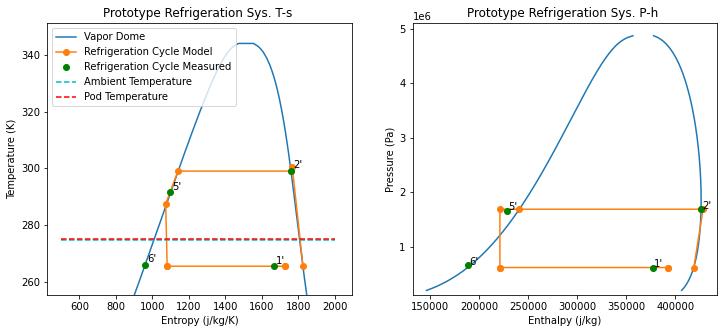

[-0.21027796  0.15446173 -0.20857545]


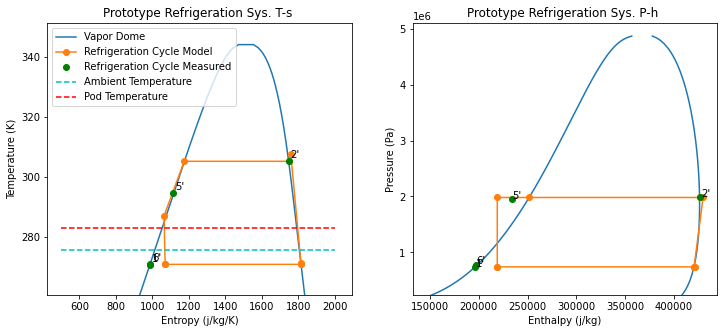

[-0.42445857 -0.00260766 -0.0190631 ]


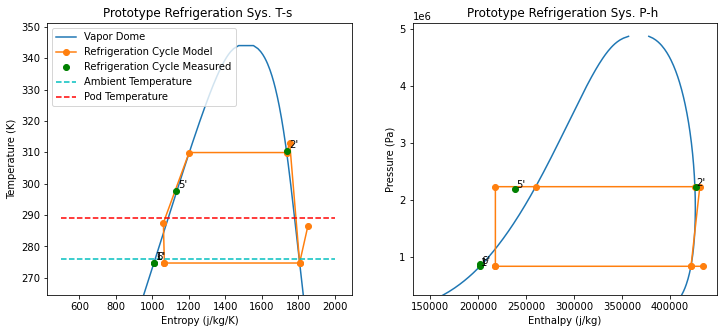

[-0.57326387 -0.05807698  0.14019723]


<ipython-input-15-f23e015d8b12>:119: UserWarning: Partial Evaporation
  warnings.warn('Partial Evaporation')
C:\ProgramData\Anaconda3\envs\jupyterlab-debugger\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


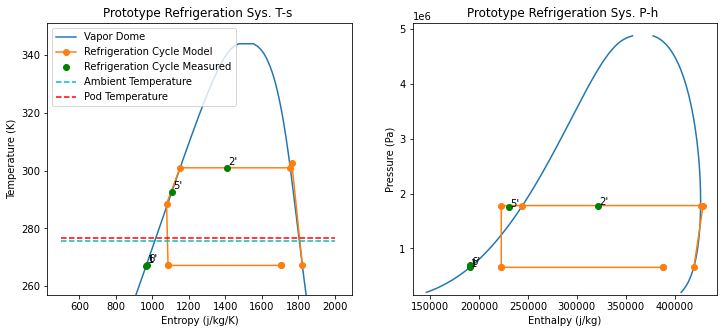

[-0.22412141  0.18786406 -0.19566876]


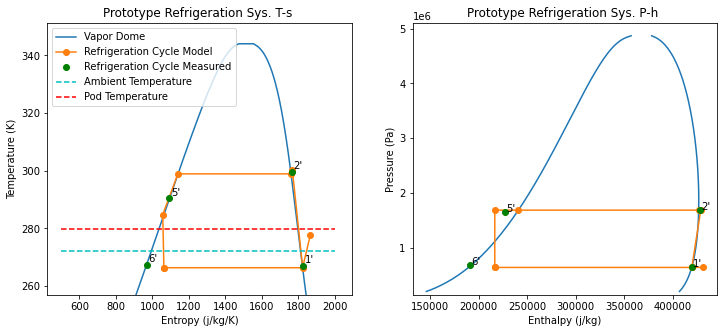

[-0.2503232  -0.05411365 -0.11015841]


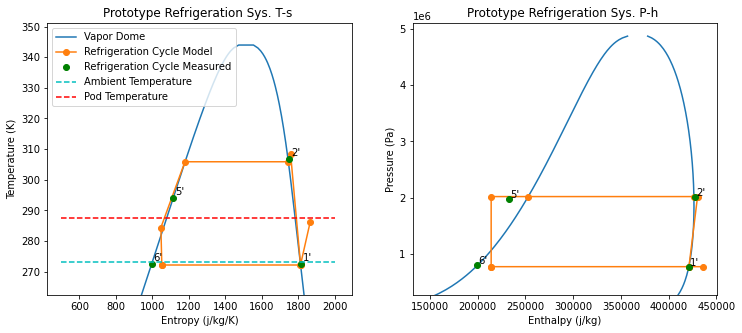

[-0.51835911 -0.06672902  0.10549504]


<ipython-input-15-f23e015d8b12>:119: UserWarning: Partial Evaporation
  warnings.warn('Partial Evaporation')
C:\ProgramData\Anaconda3\envs\jupyterlab-debugger\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


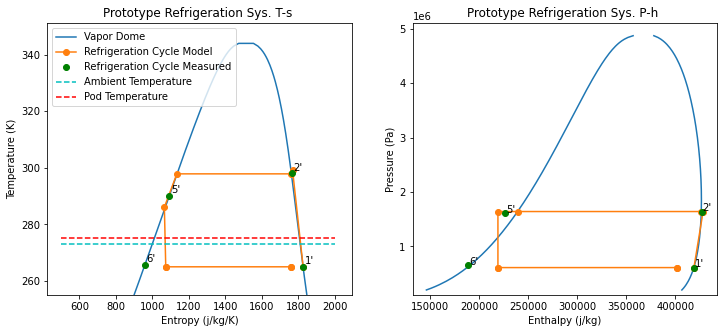

[-0.19402849  0.09607128 -0.15399987]


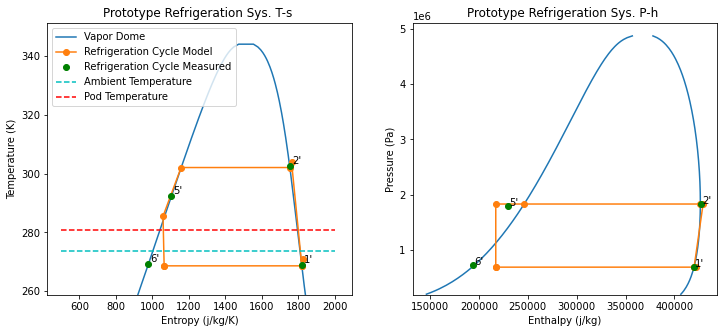

[-0.35474765 -0.01141705 -0.06627867]


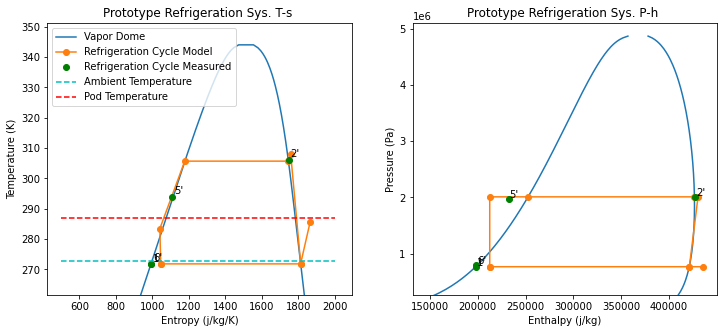

[-0.58140743 -0.06438078  0.09573418]


<ipython-input-15-f23e015d8b12>:119: UserWarning: Partial Evaporation
  warnings.warn('Partial Evaporation')
C:\ProgramData\Anaconda3\envs\jupyterlab-debugger\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


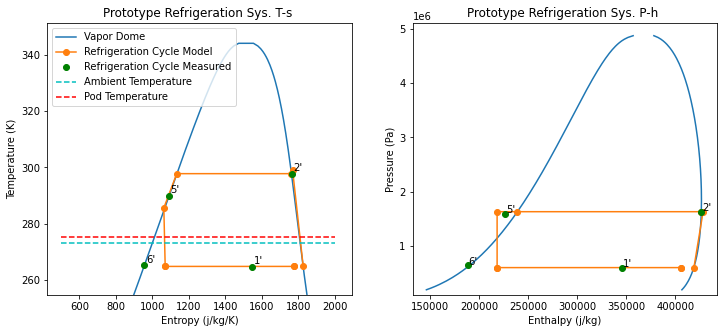

[-0.21984743  0.07280689 -0.14370866]


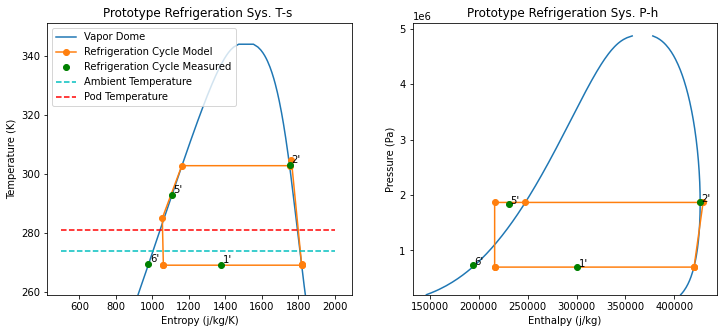

[-0.42923522 -0.00211576 -0.08559483]


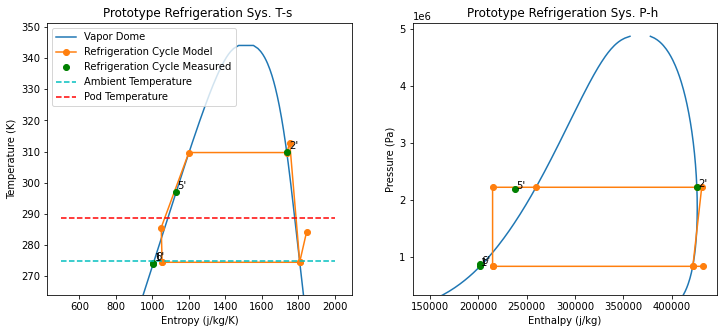

[-0.67472256 -0.04867626  0.12842528]


In [45]:
from analysis_functions import *

makeData = pd.DataFrame()

for index, row in experimentalData.iterrows():
    
#     if index == 0:

    Inputs = np.array([
                       row['Ambient T (K)'],
                       row['Pod T (K)'],
                       row['Total Heat Load (W)'],
                      ])

    Param = np.array([1500,
                      2600, # Matches HT-900 CFM of 350 CFM and ~ 40: W measured with power meter 01/22 https://www.cnet.com/products/honeywell-ht-900-turboforce-air-circulator-fan/
                      3300 # Matches 80 W measured with power meter 01/22
                     ])

    [P, T, h, s, abscissa, m_dot, Q_L, Q_H, W, W_fan_c, W_fan_e, COSP, Deficit] = make_cycle([row['P (Pa)'][1], row['P (Pa)'][0], 0.1],
                                                                                             Inputs,
                                                                                             Param)

    makeData = makeData.append(pd.DataFrame({'P (Pa)': [P], 'T (K)': [T], 'h (j/kg)': [h], 's (j/kg K)': [s], 'abcissa': [abscissa], 
                                               'Mass Flux (kg/s)': [m_dot], 'Evaporator Heat Transfer (W)': Q_L, 'Condenser Heat Transfer (W)': Q_H, 'Compressor Work (W)': W, 
                                               'Condenser Fan Work': W_fan_c, 'Evapoator Fan Work': W_fan_e, 'COSP': COSP, 'Deficits': [Deficit]}))
    

    thermodynamic_plots(experimentalData.iloc[index], makeData.iloc[-1], lgnd = ['Vapor Dome', 'Refrigeration Cycle Model',
                        'Refrigeration Cycle Measured', 'Ambient Temperature',
                       'Pod Temperature'], annotate = True)
    print(Deficit)


makeData = makeData.reset_index()

In [36]:
def parkEtAl(P_in, h_in, T_in):
    
    d_coil = 2 * 0.0254
    # 1/16" in OD copper tubing, .02" wall thickness

    # interior diameter of capillary tube
    D_c = 0.04 * 0.0254
    
    # length of capillary tube.  in diameter coil, 4 loops, 2 tubes.
#     L_c = sym.Symbol('L_c')
    L_c = d_coil * np.pi  * 4

    # Saturation Pressure
    P_sat = CP.PropsSI('P', 'T', T_in, 'Q', 0, 'R410a')
    
    # Critical Pressure
    P_crit = CP.PropsSI('PCRIT', 'R410a')
    
    # Critical Temperature
    T_crit = CP.PropsSI('TCRIT', 'R410a')
    
    # delta subcool
    T_SC = CP.PropsSI('T', 'P', P_in, 'Q', 0, 'R410a') - T_in

    # Dynamic viscosity of r-410a fluid at inlet temperature
    mu_f = CP.PropsSI('V', 'T', T_in, 'Q', 0, 'R410a')

    # Dynamic viscosity of r-410a vapor at inlet temperature
    mu_g = CP.PropsSI('V', 'T', T_in, 'Q', 1, 'R410a')

    # Density of r-410a fluid at inlet temperature
    rho_f = CP.PropsSI('D', 'T', T_in, 'Q', 0, 'R410a')

    # Density of r-410a vapor at inlet temperature
    rho_g = CP.PropsSI('D', 'T', T_in, 'Q', 1, 'R410a')
    
    # kinematic viscosity of r-410a fluid at inlet temperature
    nu_f = mu_f / rho_f

    # kinematic viscosity of r-410a vapor at inlet temperature
    nu_g = mu_g / rho_g

    # Specific volume of r-410a fluid at inlet temperature
    v_f = 1 / rho_f

    # Specific volume of r-410a vapor at inlet temperature
    v_g = 1 / rho_g

    # Saturated liquid surface tension of r-410a vapor at inlet temperature
    sigma = CP.PropsSI('I', 'T', T_in, 'Q', 0, 'R410a')

    # Enthalpy of vaporization at inlet temperature
    h_fgc = (CP.PropsSI('H', 'T', T_in, 'Q', 1, 'R410a') - 
             CP.PropsSI('H', 'T', T_in, 'Q', 0, 'R410a'))

    # Enthalpy of fluid at inlet pressure
    h_f = CP.PropsSI('H', 'P', P_in, 'Q', 0, 'R410a')

    # Enthalpy of vaporization at inlet pressure
    h_fg = (CP.PropsSI('H', 'P', P_in, 'Q', 1, 'R410a') - 
             CP.PropsSI('H', 'P', P_in, 'Q', 0, 'R410a'))
    

    # A generalized continuous empirical correlation for predicting refrigerant
    # mass flow rates through adiabatic capillary tubes

    pi_1 = (P_in - P_sat) / P_crit
    pi_2 = T_SC / T_crit
    pi_3 = L_c / D_c
    pi_4 = (nu_g - nu_f) / nu_g
    pi_5 = sigma / d_coil / P_in
    pi_6 = rho_f * h_fg / P_sat
    
    if T_SC < 0:
        warnings.warn('Warning cavitation in expansion valve')
        m_dot = 0
    else:
        pi_7 = (0.0081 * pi_1**0.1046 * pi_2**0.0182 * pi_3**-0.3903 * 
            pi_4**-0.8836 * pi_5**-0.1396 *pi_6**0.6712)
        
        m_dot = pi_7 * d_coil**2 * np.sqrt(P_in * rho_f)
    
    return m_dot 



def rastiEtAl(P_in, h_in, T_in):
    
    
    # Diameter of capillary tube coil
    d_coil = 2 * 0.0254
    
    # 1/16" in OD copper tubing, .02" wall thickness
    D_c = 0.021 * 0.0254
    
    # length of capillary tube. 4 loops
    L_c = d_coil * np.pi  * 4

    # Saturation Pressure
    P_sat = CP.PropsSI('P', 'T', T_in, 'Q', 0, 'R410a')

    # Dynamic viscosity of r-410a fluid at inlet temperature
    mu_f = CP.PropsSI('V', 'T', T_in, 'Q', 0, 'R410a')

    # Dynamic viscosity of r-410a vapor at inlet temperature
    mu_g = CP.PropsSI('V', 'T', T_in, 'Q', 1, 'R410a')

    # Density of r-410a fluid at inlet temperature
    rho_f = CP.PropsSI('D', 'T', T_in, 'Q', 0, 'R410a')

    # Density of r-410a vapor at inlet temperature
    rho_g = CP.PropsSI('D', 'T', T_in, 'Q', 1, 'R410a')

    # Specific volume of r-410a fluid at inlet temperature
    v_f = 1 / rho_f

    # Specific volume of r-410a vapor at inlet temperature
    v_g = 1 / rho_g

    # Saturated liquid surface tension of r-410a vapor at inlet temperature
    sigma = CP.PropsSI('I', 'T', T_in, 'Q', 0, 'R410a')

    # Enthalpy of fluid at inlet pressure
    h_f = CP.PropsSI('H', 'P', P_in, 'Q', 0, 'R410a')

    # Enthalpy of vaporization at inlet pressure
    h_fg = (CP.PropsSI('H', 'P', P_in, 'Q', 1, 'R410a') - 
             CP.PropsSI('H', 'P', P_in, 'Q', 0, 'R410a'))

    # A generalized continuous empirical correlation for predicting refrigerant
    # mass flow rates through adiabatic capillary tubes

    pi_1 = L_c / D_c
    pi_2 = D_c**2 * h_fg / v_f**2 / mu_f**2
    pi_3 = D_c * sigma / v_f / mu_f**2
    pi_4 = D_c**2 * P_in / v_f / mu_f**2
    pi_5 = 1 + (h_in - h_f) / h_fg
    pi_6 = v_g / v_f
    pi_7 = (mu_f - mu_g) / mu_g
    pi_9 = 1 + L_c / d_coil
    
    if h_in < h_f: # Subcooled
        c_5 = 0.6436
    else: # Two Phase
        c_5 = -1.971
        
    pi_8 = 150.26 * pi_1**-0.5708 * pi_2**-1.4636 * pi_4**1.953 * pi_5**c_5 * pi_6**1.4181 * pi_9**-0.0158
        
    m_dot = 2 * pi_8 * D_c * mu_f
    
    return m_dot 

def kimEtAl(P_in, h_in, T_in):
    # Mass flow rate correlation for helically coiled capillary tubes Kim et al.
    
    # Diameter of capillary tube coil
    d_coil = 2 * 0.0254
    
    # 1/16" in OD copper tubing, .02" wall thickness
    D_c = 0.021 * 0.0254
    
    # length of capillary tube. 4 loops
    L_c = d_coil * np.pi  * 4

    # delta subcool
    T_SC = CP.PropsSI('T', 'P', P_in, 'Q', 0, 'R410a') - T_in
    
    # Isobaric specific heat capacity of r-410a fluid at inlet temperature
    C_pf = CP.PropsSI('C', 'P', P_in, 'Q', 0, 'R410a')

    # Dynamic viscosity of r-410a fluid at inlet temperature
    mu_f = CP.PropsSI('V', 'T', T_in, 'Q', 0, 'R410a')

    # Dynamic viscosity of r-410a vapor at inlet temperature
    mu_g = CP.PropsSI('V', 'T', T_in, 'Q', 1, 'R410a')

    # Density of r-410a fluid at inlet temperature
    rho_f = CP.PropsSI('D', 'T', T_in, 'Q', 0, 'R410a')

    # Density of r-410a vapor at inlet temperature
    rho_g = CP.PropsSI('D', 'T', T_in, 'Q', 1, 'R410a')

    # Specific volume of r-410a fluid at inlet temperature
    v_f = 1 / rho_f

    # Specific volume of r-410a vapor at inlet temperature
    v_g = 1 / rho_g

    # Saturated liquid surface tension of r-410a vapor at inlet temperature
    sigma = CP.PropsSI('I', 'T', T_in, 'Q', 0, 'R410a')

    # Enthalpy of fluid at inlet pressure
    h_f = CP.PropsSI('H', 'P', P_in, 'Q', 0, 'R410a')

    # Enthalpy of vaporization at inlet pressure
    h_fg = (CP.PropsSI('H', 'P', P_in, 'Q', 1, 'R410a') - 
             CP.PropsSI('H', 'P', P_in, 'Q', 0, 'R410a'))

    # A generalized continuous empirical correlation for predicting refrigerant
    # mass flow rates through adiabatic capillary tubes

    pi_1 = D_c**2 * P_in / v_f / mu_f**2
    pi_2 = L_c / D_c
    pi_3 = T_SC * C_pf * D_c**2 / v_f**2 / mu_f**2 
    pi_4 = D_c**2 * h_fg / v_f**2 / mu_f**2
    pi_5 = D_c * sigma / v_f / mu_f**2
    pi_6 = d_coil / D_c
  
    pi_7 = 1.5104 * pi_1**0.5351 * pi_2**-0.3785 * pi_3**0.1074 * pi_4**-0.1596 * pi_5**0.0962 * 0.7887 * pi_6**0.0424
    
    m_dot = 2 * pi_7 * D_c * mu_f
    
    return m_dot 

def rastiEtAl(P_in, h_in, T_in):
    # Mass flow rate correlation for helically coiled capillary tubes Rasti et al.
  
    # Diameter of capillary tube coil
    d_coil = 2 * 0.0254
    
    # 1/16" in OD copper tubing, .02" wall thickness
    D_c = 0.022 * 0.0254
    
    # length of capillary tube. 4 loops
    L_c = d_coil * np.pi  * 4

    # Saturation Pressure
    P_sat = CP.PropsSI('P', 'T', T_in, 'Q', 0, 'R410a')

    # Dynamic viscosity of r-410a fluid at inlet temperature
    mu_f = CP.PropsSI('V', 'T', T_in, 'Q', 0, 'R410a')

    # Dynamic viscosity of r-410a vapor at inlet temperature
    mu_g = CP.PropsSI('V', 'T', T_in, 'Q', 1, 'R410a')

    # Density of r-410a fluid at inlet temperature
    rho_f = CP.PropsSI('D', 'T', T_in, 'Q', 0, 'R410a')

    # Density of r-410a vapor at inlet temperature
    rho_g = CP.PropsSI('D', 'T', T_in, 'Q', 1, 'R410a')

    # Specific volume of r-410a fluid at inlet temperature
    v_f = 1 / rho_f

    # Specific volume of r-410a vapor at inlet temperature
    v_g = 1 / rho_g

    # Saturated liquid surface tension of r-410a vapor at inlet temperature
    sigma = CP.PropsSI('I', 'T', T_in, 'Q', 0, 'R410a')

    # Enthalpy of fluid at inlet pressure
    h_f = CP.PropsSI('H', 'P', P_in, 'Q', 0, 'R410a')

    # Enthalpy of vaporization at inlet pressure
    h_fg = (CP.PropsSI('H', 'P', P_in, 'Q', 1, 'R410a') - 
             CP.PropsSI('H', 'P', P_in, 'Q', 0, 'R410a'))

    # A generalized continuous empirical correlation for predicting refrigerant
    # mass flow rates through adiabatic capillary tubes

    pi_1 = L_c / D_c
    pi_2 = D_c**2 * h_fg / v_f**2 / mu_f**2
    pi_3 = D_c * sigma / v_f / mu_f**2
    pi_4 = D_c**2 * P_in / v_f / mu_f**2
    pi_5 = 1 + (h_in - h_f) / h_fg
    pi_6 = v_g / v_f
    pi_7 = (mu_f - mu_g) / mu_g
    pi_9 = 1 + L_c / d_coil
    
    if h_in < h_f: # Subcooled
        c_5 = 0.6436
    else: # Two Phase
        c_5 = -1.971
        
    pi_8 = 150.26 * pi_1**-0.5708 * pi_2**-1.4636 * pi_4**1.953 * pi_5**c_5 * pi_6**1.4181 * pi_9**-0.0158
        
    m_dot = 2 * pi_8 * D_c * mu_f
    
    return m_dot 

def compr_func( inlet_state, RPM, P_ratio):

    P_e   = inlet_state[0] # Pa
    h_e_o = inlet_state[1] # j/kg
        

    #Param
    eta_v = 2 * (1 - 0.2 * P_ratio) # Volumetric efficiency
    Disp = 5.25E-6    # [m^3 per rev] #volume displacement
    
    if eta_v < 0:
        raise ValueError('Compression ratio too high')

    h_g   = CP.PropsSI('H', 'P', P_e, 'Q', 1, 'R410a')
    if h_e_o < h_g:
        warnings.warn('Flooded Compressor, vapor quality < 1')
    
    rho = CP.PropsSI('D', 'P', P_e, 'H' ,h_e_o, 'R410a')

    m_dot = RPM / 60 * Disp * eta_v * rho
    
    return m_dot


[0.00310328 0.00369133 0.00397189 0.00679386 0.00364026 0.00381872
 0.00305998 0.0036158  0.00381099 0.00307018 0.00372229 0.00399383]
[0.00319197 0.00404116 0.00473642 0.00340657 0.00328984 0.00426082
 0.0031346  0.00367867 0.00428341 0.00313857 0.003765   0.00475564]
[0.00282788 0.00344389 0.00392757 0.00300142 0.00302321 0.00369357
 0.00283508 0.00323376 0.00363505 0.00280961 0.00325284 0.00389411]


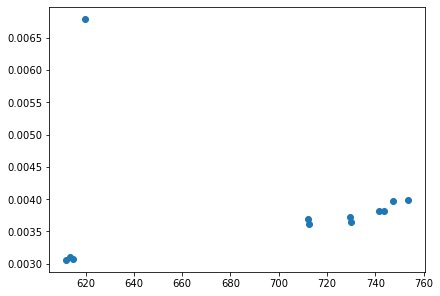

In [39]:

m = np.array([])
compressor = np.array([])
cap = np.array([])
RPM = np.array([])
rho = np.array([])

for ind, row in experimentalData.iterrows():
    m = np.append(m, row['Total Heat Load (W)'] / (row['h (j/kg)'][1] - row['h (j/kg)'][2]))
    rho = np.append(rho, CP.PropsSI('D', 'P', row['P (Pa)'][3], 'H', row['h (j/kg)'][0], 'R410a'))
    cap = np.append(cap, rastiEtAl(row['P (Pa)'][2], row['h (j/kg)'][2], row['T (K)'][2]))
    T_in = CP.PropsSI('T', 'P', row['P (Pa)'][0], 'Q' , 1, 'R410a') + 0.5
    compressor = np.append(compressor, compr_func([row['P (Pa)'][0],
                                                   CP.PropsSI('H', 'P', row['P (Pa)'][0], 'T', T_in, 'R410a')], 
                                                  1500, 
                                                  row['P (Pa)'][1] / row['P (Pa)'][0]))
    
#     def obj(x):
#         k = compr_func([row['P (Pa)'][0], row['h (j/kg)'][0]], x, row['P (Pa)'][1] / row['P (Pa)'][0]) - m[ind]
#         return k
    
#     RPM = np.append(RPM, root_scalar(f=obj, x0 = 750, bracket = [400,  10000]).root)
#     compressor = np.append(compressor, compr_func([row['P (Pa)'][0], row['h (j/kg)'][0]], RPM[ind], row['P (Pa)'][1] / row['P (Pa)'][0]))
print(m)
print(cap)    
print(compressor)
fig, ax = plt.subplots(constrained_layout=True)
# plt.plot(RPM, compressor, 'o')
plt.plot(experimentalData['Total Heat Load (W)'], m, 'o')
# plt.plot(compressor, m, 'o')
# plt.plot(experimentalData['Total Heat Load (W)'], rho,'o')
# secax = ax.secondary_yaxis('right', functions=(, ))
# plt.plot(RPM, rho,'.')
# RPM_fit = np.polyfit(experimentalData['Total Heat Load (W)'] / rho, RPM, 1)
# plt.plot(np.unique(experimentalData['Total Heat Load (W)'] / rho), np.poly1d(RPM_fit)(np.unique(experimentalData['Total Heat Load (W)'] / rho)))

# plt.plot(m, compressor, 'o')
# plt.plot(compressor, RPM)
plt.show()

In [33]:
error_P = []
error_T = []

for index, row in experimentalData.iterrows():
    one_P = (modelData.iloc[index]['P (Pa)'][0] - row['P (Pa)'][0]) / row['P (Pa)'][0]
    two_P = (modelData.iloc[index]['P (Pa)'][1] - row['P (Pa)'][1]) / row['P (Pa)'][1]
    five_P = (modelData.iloc[index]['P (Pa)'][4] - row['P (Pa)'][2]) / row['P (Pa)'][2]
    six_P = (modelData.iloc[index]['P (Pa)'][5] - row['P (Pa)'][3]) / row['P (Pa)'][3]
    error_P.append([one_P, two_P, five_P, six_P])
    
    one_T = (modelData.iloc[index]['T (K)'][0] - row['T (K)'][0]) 
    two_T = (modelData.iloc[index]['T (K)'][1] - row['T (K)'][1])
    five_T = (modelData.iloc[index]['T (K)'][4] - row['T (K)'][2])
    six_T = (modelData.iloc[index]['T (K)'][5] - row['T (K)'][3])
    error_T.append([one_T, two_T, five_T, six_T])
    
modelData['Pressure Error'] = error_P
modelData['Temperature Error'] = error_T
modelData['Heat Rejection Error'] = (modelData['Evaporator Heat Transfer (W)'] - experimentalData['Total Heat Load (W)']) / experimentalData['Total Heat Load (W)']
modelData['Work Error'] = (modelData['Compressor Work (W)'] - experimentalData['Compressor Work (W)']) / experimentalData['Compressor Work (W)']
modelData['COP Error'] = (modelData['Evaporator Heat Transfer (W)'] / modelData['Compressor Work (W)']  - experimentalData['COP']) / experimentalData['COP']
modelData['COSP Error'] = (modelData['COSP']  - experimentalData['COSP']) / experimentalData['COSP']


In [12]:
for index, row in modelData.iterrows():
    print(max(row['Pressure Error']))

-0.05303289774673203
2.211289244120735
4.5300259973166135
0.038445260148307625
2.746232193718015
4.9267101098261605
0.4025147940573106
1.8625462229309733
4.8937531304297295
0.6975276693701744
1.7733172789643845
3.724791238124112
